In [1]:
import ray
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from datetime import datetime, timedelta

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange,ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed

from gym.spaces import Discrete
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair, Instrument
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer

import ray.rllib.agents.ppo as ppo

### Renderer (Plot)

In [2]:
class PositionChangeChart(Renderer):
    """The Renderer renders a view of the environment and interactions."""
    
    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        # The Observer generates the next observation for the agent.
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="v", color="red") # BUY
        axs[0].scatter(sell.index, sell.values, marker="^", color="green") # SELL
        axs[0].set_title("Trading Chart")
        axs[0].legend(['Price', 'Buys', 'Sells'])

        performance_df = pd.DataFrame().from_dict(env.action_scheme.portfolio.performance, orient='index')
        performance_df.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

---

### DRL Model

### Train

Now in order to use our custom environment in ray we must first write a function that creates an instance of the TradingEnv from a configuration dictionary.

In [38]:
def generate_train_test_datasets(ticker, train_test_split):
    """Get Yahoo! Finance Data for Train/Test Splits."""

    yf_ticker = yf.Ticker(ticker=f'{ticker}.SA')

    df = yf_ticker.history(period='1y', interval='1h')
    df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
    df["Volume"] = df["Volume"].fillna(0).astype(int)
    df.ta.log_return(append=True, length=16)
    df.ta.rsi(append=True, length=14)
    df.ta.macd(append=True, fast=12, slow=26)
    df.dropna(inplace=True)

    next_day = datetime.strptime(train_test_split, '%Y-%m-%d')
    next_day = next_day + timedelta(days=1)
    next_day = next_day.strftime('%Y-%m-%d')

    df_training = df.loc[:train_test_split].copy()
    df_evaluation = df.loc[next_day:].copy()

    df_training.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
    df_evaluation.rename(columns={'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)

    df_training.dropna().to_csv('../../data/testing/training.csv', index=True)
    df_evaluation.dropna().to_csv('../../data/testing/evaluation.csv', index=True)

    return df_training, df_evaluation

In [39]:
df_train, df_test = generate_train_test_datasets('PETR4', '2021-08-27')

In [43]:
df_train.tail()

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2021-08-27 12:00:00-03:00,28.040001,28.160000,27.980000,28.150000,12030400,0.022998,67.699115,0.183076,0.027274,0.155802
2021-08-27 13:00:00-03:00,28.150000,28.280001,28.100000,28.270000,7911400,0.026162,69.964186,0.208712,0.042328,0.166384
2021-08-27 14:00:00-03:00,28.280001,28.280001,28.150000,28.230000,4817600,0.026199,68.246213,0.223227,0.045475,0.177752
2021-08-27 15:00:00-03:00,28.230000,28.350000,28.180000,28.320000,9474100,0.030110,70.029389,0.239235,0.049186,0.190049
2021-08-27 16:00:00-03:00,28.309999,28.490000,28.299999,28.459999,9437800,0.032860,72.606394,0.260219,0.056136,0.204083


In [41]:
df_test.head()

,Open,High,Low,Close,Volume,LOGRET_16,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
2021-08-30 10:00:00-03:00,28.400000,28.650000,28.260000,28.360001,0,0.019225,68.102047,0.265717,0.049307,0.216410
2021-08-30 11:00:00-03:00,28.360001,28.639999,28.309999,28.600000,17729600,0.032697,72.509973,0.286141,0.055785,0.230356
2021-08-30 12:00:00-03:00,28.600000,28.709999,28.520000,28.549999,6784500,0.025902,70.329441,0.294894,0.051630,0.243264
2021-08-30 13:00:00-03:00,28.540001,28.620001,28.510000,28.570000,4177000,0.030203,70.708883,0.299986,0.045378,0.254608
2021-08-30 14:00:00-03:00,28.570000,28.590000,28.340000,28.350000,6541200,0.021031,61.406393,0.283007,0.022719,0.260288


---

In [7]:
def create_training_env(config):
    """Creates Trading Environment. """
    
    # 1. Data and TensorTrade Objects

    ticker = 'PETR4'
    
    dataset = pd.read_csv(filepath_or_buffer="../../data/testing/training.csv", 
                          parse_dates=True).fillna(method='backfill').fillna(method='ffill')
    
    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    feed = DataFeed(features)
    feed.compile()
    
    # 2. Rewards

    # Rewards - Risk Adjusted
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # 3. Actions

    # action_scheme = default.actions.ManagedRiskOrders(
    #     stop=[0.05],
    #     take=[0.075],
    #     min_order_pct=0.5
    # )

    # A discrete action scheme that determines actions based on managing risk
    action_scheme = default.actions.ManagedRiskOrders()

    # 4. Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset.index)).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    # 5. Environment
    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment

register_env("TradingEnv", create_training_env)

---

Now that the environment is registered we can run the training algorithm using the Proximal Policy Optimization (PPO) algorithm implemented in rllib.

In [8]:
window_size = 35

env_config_training = {
    # We want to look at the last 14 samples (hours)
    "window_size": window_size, # hours * days
    # And calculate reward based on the actions taken in the next 7 hours
    #"reward_window_size": 7,
    # If it goes past 10% loss during the iteration, we don't want to waste time on a "loser".
    "max_allowed_loss": 0.10,
}

analysis = tune.run(
    # We'll be using the builtin PPO agent in RLLib
    run_or_experiment="PPO",
    name="MyExperiment1",
    metric='episode_reward_mean',
    stop={
      "episode_reward_mean": 0.05
    },
    config={
        "env": "TradingEnv",
        "env_config": env_config_training,
        "log_level": "DEBUG",
        "framework": "tf2",
        "eager_tracing": True,
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2022-04-26 17:02:27,711	INFO services.py:1338 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc
PPO_TradingEnv_d20d6_00000,PENDING,


2022-04-26 17:02:37,862	ERROR syncer.py:111 -- Log sync requires rsync to be installed.
 pid=22836) 2022-04-26 17:02:43,027	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=True. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=13036) 2022-04-26 17:02:48,245	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=13036) 2022-04-26 17:02:48,296	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=13036) 2022-04-26 17:02:48,306	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000001D08648F040>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=13036)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=13036)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=13036)  [-inf -inf -inf -inf 

Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


 pid=22836) 2022-04-26 17:02:51,931	INFO rollout_worker.py:1555 -- Built policy map: {}
 pid=22836) 2022-04-26 17:02:51,931	INFO rollout_worker.py:1556 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000026233D1DB80>}
 pid=22836) 2022-04-26 17:02:51,931	INFO rollout_worker.py:618 -- Built filter map: {'default_policy': MeanStdFilter((35, 10), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
 pid=22836) 2022-04-26 17:02:51,931	DEBUG rollout_worker.py:728 -- Created rollout worker with env None (None), policies {}
 pid=22836) 2022-04-26 17:02:51,940	WARNING util.py:57 -- Install gputil for GPU system monitoring.
 pid=13036) 2022-04-26 17:02:52,767	INFO rollout_worker.py:754 -- Generating sample batch of size 200
 pid=13036) 2022-04-26 17:02:52,767	DEBUG sampler.py:568 -- No episode horizon specified, assuming inf.
 pid=13036) 2022-04-26 17:02:52,768	INFO sampler.py:624 -- Raw obs from env:

Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


 pid=13036) 2022-04-26 17:02:53,824	INFO simple_list_collector.py:781 -- Trajectory fragment after postprocess_trajectory():
 pid=13036) tWorker
 pid=13036) { 'agent0': { 'action_dist_inputs': np.ndarray((200, 181), dtype=float32, min=-0.021, max=0.021, mean=0.0),
 pid=13036)               'action_logp': np.ndarray((200,), dtype=float32, min=-5.212, max=-5.186, mean=-5.199),
 pid=13036)               'actions': np.ndarray((200,), dtype=int64, min=0.0, max=180.0, mean=87.795),
 pid=13036)               'advantages': np.ndarray((200,), dtype=float32, min=-1.015, max=1.016, mean=0.003),
 pid=13036)               'agent_index': np.ndarray((200,), dtype=int32, min=0.0, max=0.0, mean=0.0),
 pid=13036)               'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
 pid=13036)               'eps_id': np.ndarray((200,), dtype=int32, min=1237136822.0, max=1237136822.0, mean=1237136822.0),
 pid=13036)               'infos': np.ndarray((200,), dtype=object, head={'step': 1, 'ne

Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


 pid=22836) 2022-04-26 17:03:15,074	WARNING deprecation.py:45 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
 pid=22836) 2022-04-26 17:03:15,075	WARNING deprecation.py:45 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!
 pid=22836) 2022-04-26 17:03:15,076	INFO rollout_worker.py:836 -- Training on concatenated sample batches:
 pid=22836) 
 pid=22836) { 'count': 128,
 pid=22836)   'policy_batches': { 'default_policy': { 'action_dist_inputs': np.ndarray((128, 181), dtype=float32, min=-0.018, max=0.019, mean=0.0),
 pid=22836)                                           'action_logp': np.ndarray((128,), dtype=float32, min=-5.211, max=-5.186, mean=-5.198),
 pid=22836)                                           'actions': np.ndarray((128,), dtype=int64, min=0.0, max=180.0, mean=80.992),
 pid=22836)                                           'advantages': np.n

Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


Trial name,status,loc
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836


Result for PPO_TradingEnv_d20d6_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-04-26_17-03-31
  done: true
  episode_len_mean: 554.0
  episode_media: {}
  episode_reward_max: 0.09242316116693206
  episode_reward_mean: 0.07171230213546617
  episode_reward_min: 0.060371799034516505
  episodes_this_iter: 7
  episodes_total: 7
  experiment_id: 943655f2631b4816b314d1771458a81b
  hostname: DESKTOP-625611C
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 0.10000000149011612
          entropy: 5.197342872619629
          entropy_coeff: 0.009999999776482582
          kl: 0.0011391397565603256
          policy_loss: -0.019007958471775055
          total_loss: 0.397926390171051
          vf_explained_var: 0.018393348902463913
          vf_loss: 0.9373598694801331
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_sinc

 pid=22836) 2022-04-26 17:03:31,339	DEBUG trainer.py:1741 -- synchronized filters: {'default_policy': MeanStdFilter((35, 10), True, True, None, (n=4008, mean_mean=719390.0248657006, mean_std=568713.9472764338), (n=0, mean_mean=0.0, mean_std=0.0))}


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_d20d6_00000,RUNNING,127.0.0.1:22836,1,39.388,4000,0.0717123,0.0924232,0.0603718,554


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_d20d6_00000,TERMINATED,127.0.0.1:22836,1,39.388,4000,0.0717123,0.0924232,0.0603718,554


2022-04-26 17:03:34,492	INFO tune.py:626 -- Total run time: 56.86 seconds (56.23 seconds for the tuning loop).


---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [9]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean", mode="max"),
    metric="episode_reward_mean"    
)

checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": env_config_training,
        "log_level": "DEBUG",
        "framework": "tf2",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 1,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "model": {
            "fcnet_hiddens": [256, 256], # Hyperparameter grid search defined above
        },
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
)

2022-04-26 17:03:34,667	INFO trainer.py:712 -- Executing eagerly (framework='tf2'), with eager_tracing=False. For production workloads, make sure to set `eager_tracing=True` in order to match the speed of tf-static-graph (framework='tf'). For debugging purposes, `eager_tracing=False` is the best choice.
 pid=22588) 2022-04-26 17:03:39,936	INFO rollout_worker.py:1705 -- Validating sub-env at vector index=0 ... (ok)
 pid=22588) 2022-04-26 17:03:39,982	DEBUG rollout_worker.py:1534 -- Creating policy for default_policy
 pid=22588) 2022-04-26 17:03:39,993	DEBUG catalog.py:706 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x0000020EEB29FB20>: Box([[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=22588)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=22588)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=22588)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pid=22588)  [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
 pi

---

After training is complete, we would now like to get access to the agents policy. We can do that by restoring the agent using the following code.

In [10]:
# Restore agent
agent.restore(checkpoint_path)

# Instantiate the environment
env = create_training_env({
    "window_size": window_size
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

2022-04-26 17:03:45,999	INFO trainable.py:467 -- Restored on 127.0.0.1 from checkpoint: C:\Users\mathe\ray_results\MyExperiment1\PPO_TradingEnv_d20d6_00000_0_2022-04-26_17-02-37\checkpoint_000001\checkpoint-1
2022-04-26 17:03:46,000	INFO trainable.py:475 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': 0, '_time_total': 39.38801312446594, '_episodes_total': 7}


FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

---

### Validation Set

In [11]:
def create_eval_env(config):
    """Creates the Evaluation Environment."""
    dataset = pd.read_csv(filepath_or_buffer="../../data/testing/evaluation.csv", 
                          parse_dates=True).fillna(method='backfill').fillna(method='ffill')

    # Price Series
    price = Stream.source(list(dataset["close"]), dtype="float").rename("BRL-ASSETS")
    
    b3_commission = 0.0035
    b3_options = ExchangeOptions(commission=b3_commission)
    b3_exchange = Exchange("B3", service=execute_order, options=b3_options)(price)
    
    # Instruments
    BRL = Instrument("BRL", 2, "Brazilian Currency")
    ASSETS = Instrument("ASSETS", 2, "Assets")

    # Portfolio
    cash = Wallet(b3_exchange, 100000 * BRL) # Money
    asset = Wallet(b3_exchange, 0 * ASSETS) # Stocks/Assets
    
    portfolio = Portfolio(BRL, [cash, asset])
    
    features = []
    for c in dataset.columns[1:]:
        s = Stream.source(list(dataset[c]), dtype="float").rename(dataset[c].name)
        features += [s]
    feed = DataFeed(features)
    feed.compile()
    
    # Rewards - Risk Adjusted
    # reward_scheme = default.rewards.RiskAdjustedReturns(
    #     return_algorithm='sharpe',
    #     risk_free_rate=0,
    #     window_size= 7 * 5
    # )

    # Rewards - Simple Profit
    reward_scheme = default.rewards.SimpleProfit()
    
    # Actions
    # action_scheme = default.actions.ManagedRiskOrders(
    #     stop=[0.05],
    #     take=[0.075],
    #     min_order_pct=0.5
    # )

    # A discrete action scheme that determines actions based on managing risk
    action_scheme = default.actions.ManagedRiskOrders()
    
    # Visualization
    renderer_feed = DataFeed([
        Stream.source(list(dataset.index)).rename("date"),
        Stream.source(list(dataset["open"]), dtype="float").rename("open"),
        Stream.source(list(dataset["high"]), dtype="float").rename("high"),
        Stream.source(list(dataset["low"]), dtype="float").rename("low"),
        Stream.source(list(dataset["close"]), dtype="float").rename("close"),
        Stream.source(list(dataset["volume"]), dtype="float").rename("volume")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=default.renderers.PlotlyTradingChart(display=True, auto_open_html=False, save_format="png"),
        #renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.4
    )
    
    return environment, portfolio

In [12]:
# 1. Instantiate the evaluation environment
env, portfolio = create_eval_env({
    "window_size": window_size
})

# 2. Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_single_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    
env.render()

portfolio.ledger.as_frame().head(10)

FigureWidget({
    'data': [{'name': 'Price',
              'showlegend': False,
              'type': 'candle…

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),10000.00 BRL,90000.00 BRL,10000.00 BRL,10000.00 BRL
1,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),35.00 BRL,90000.00 BRL,9965.00 BRL,9965.00 BRL
2,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),9965.00 BRL,90000.00 BRL,0.00 BRL,0.00 BRL
3,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3,B3:ASSETS/locked,DEPOSIT (TRADED 9965.00 BRL B3:BRL/ASSETS @ 28...,351.38 ASSETS,0.00 ASSETS,351.38 ASSETS,351.38 ASSETS
4,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),9000.00 BRL,81000.00 BRL,9000.00 BRL,9000.00 BRL
5,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),31.50 BRL,81000.00 BRL,8968.50 BRL,8968.50 BRL
6,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),8968.50 BRL,81000.00 BRL,0.00 BRL,0.00 BRL
7,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3,B3:ASSETS/locked,DEPOSIT (TRADED 8968.50 BRL B3:BRL/ASSETS @ 28...,313.58 ASSETS,0.00 ASSETS,664.96 ASSETS,313.58 ASSETS
8,f206b956-2ee5-4938-96e8-b432cd8cc917,4,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),56700.00 BRL,24300.00 BRL,56700.00 BRL,56700.00 BRL
9,f206b956-2ee5-4938-96e8-b432cd8cc917,4,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),198.45 BRL,24300.00 BRL,56501.55 BRL,56501.55 BRL


In [13]:
portfolio.ledger.as_frame().head(10)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),10000.00 BRL,90000.00 BRL,10000.00 BRL,10000.00 BRL
1,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),35.00 BRL,90000.00 BRL,9965.00 BRL,9965.00 BRL
2,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),9965.00 BRL,90000.00 BRL,0.00 BRL,0.00 BRL
3,74807d9f-c279-41d7-a6dc-5a488ab41c77,1,B3,B3:ASSETS/locked,DEPOSIT (TRADED 9965.00 BRL B3:BRL/ASSETS @ 28...,351.38 ASSETS,0.00 ASSETS,351.38 ASSETS,351.38 ASSETS
4,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),9000.00 BRL,81000.00 BRL,9000.00 BRL,9000.00 BRL
5,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),31.50 BRL,81000.00 BRL,8968.50 BRL,8968.50 BRL
6,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3:BRL/locked,B3,WITHDRAWAL (FILL ORDER),8968.50 BRL,81000.00 BRL,0.00 BRL,0.00 BRL
7,b5eb1ab5-3ae3-49db-a6b2-48bbfbec36d6,2,B3,B3:ASSETS/locked,DEPOSIT (TRADED 8968.50 BRL B3:BRL/ASSETS @ 28...,313.58 ASSETS,0.00 ASSETS,664.96 ASSETS,313.58 ASSETS
8,f206b956-2ee5-4938-96e8-b432cd8cc917,4,B3:BRL/free,B3:BRL/locked,LOCK (LOCK FOR ORDER),56700.00 BRL,24300.00 BRL,56700.00 BRL,56700.00 BRL
9,f206b956-2ee5-4938-96e8-b432cd8cc917,4,B3:BRL/locked,B3,WITHDRAWAL (COMMISSION),198.45 BRL,24300.00 BRL,56501.55 BRL,56501.55 BRL


In [28]:
df = pd.DataFrame(portfolio.performance)

<AxesSubplot:>

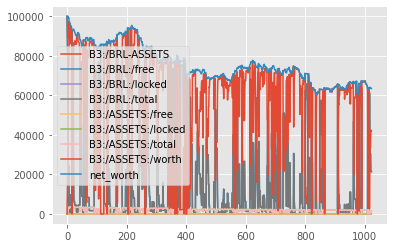

In [15]:
df.T.plot()

<AxesSubplot:>

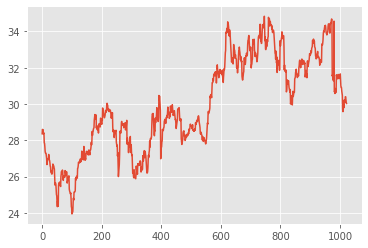

In [17]:
df.loc["B3:/BRL-ASSETS"].plot()

<AxesSubplot:>

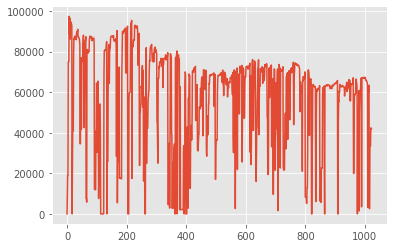

In [18]:
df.loc["B3:/ASSETS:/worth"].plot()

In [19]:
worth_streams = []
for wallet in portfolio.wallets:
    total_balance = Stream.sensor(
        wallet,
        lambda w: w.total_balance.as_float(),
        dtype="float"
    )
    
    symbol = wallet.instrument.symbol

    if symbol == portfolio.base_instrument.symbol:
        worth_streams += [total_balance]
    else:
        price = Stream.select(
        wallet.exchange.streams(),
            lambda s: s.name.endswith(symbol)
        )
        worth_streams += [(price * total_balance)]

net_worth = Stream.reduce(worth_streams).sum().rename("net_worth")

---

### Net Worth Analysis (with Quantstats)

In [23]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

In [116]:
dataset = pd.read_csv(filepath_or_buffer="../../data/testing/evaluation.csv", 
                          parse_dates=True).fillna(method='backfill').fillna(method='ffill')

dataset.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

net_worth = df.loc["net_worth"].rename('Close')
net_worth.index = dataset['Date'].loc[1:]
net_worth.index = pd.to_datetime(net_worth.index)

net_worth = net_worth.resample('D').last()
net_worth.index = net_worth.index.date
net_worth.index = net_worth.index.rename('Date')

In [117]:
net_returns = net_worth.pct_change().dropna()
net_returns.index = pd.to_datetime(net_returns.index)
net_returns

Date
2021-08-31   -0.040670
2021-09-01   -0.026128
2021-09-02   -0.009469
2021-09-03   -0.014902
2021-09-04    0.000000
                ...   
2022-04-22   -0.031952
2022-04-23    0.000000
2022-04-24    0.000000
2022-04-25   -0.016352
2022-04-26   -0.008267
Name: Close, Length: 239, dtype: float64

In [118]:
# show sharpe ratio
qs.stats.sharpe(net_returns)

-1.3776038606436425

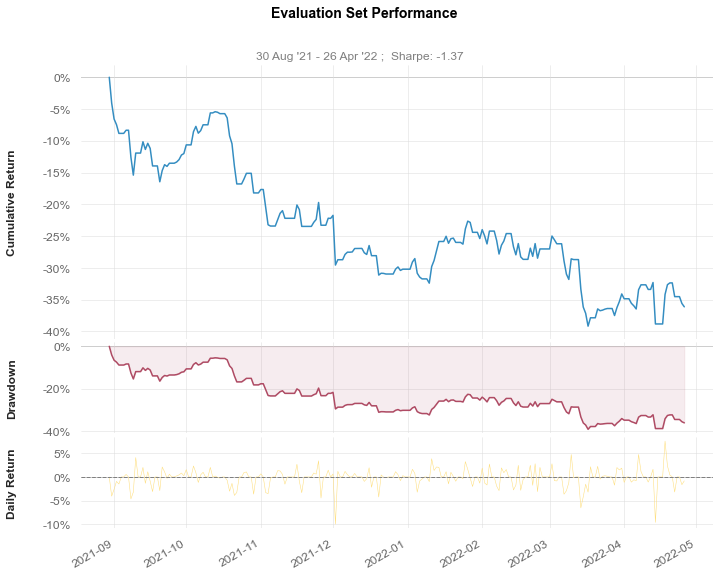

In [119]:
# Show overall performance
qs.plots.snapshot(net_returns, title=f'Evaluation Set Performance')

In [120]:
# Convert datetime to date (keep end of day result)
qs.reports.html(net_returns, "^BVSP")

---